# Tourament Predictor

### 2021 Results

In 2021, I leveraged the kaggle input data and combined with kenpom data. I then applied a Gradient Boosting Classifier and predicted the results.

My resulting bracket was pretty decent. It had an overall log loss 0.66587 of which put me at #503 (out of 707) on the Kaggle March Madness prediction leaderboard.

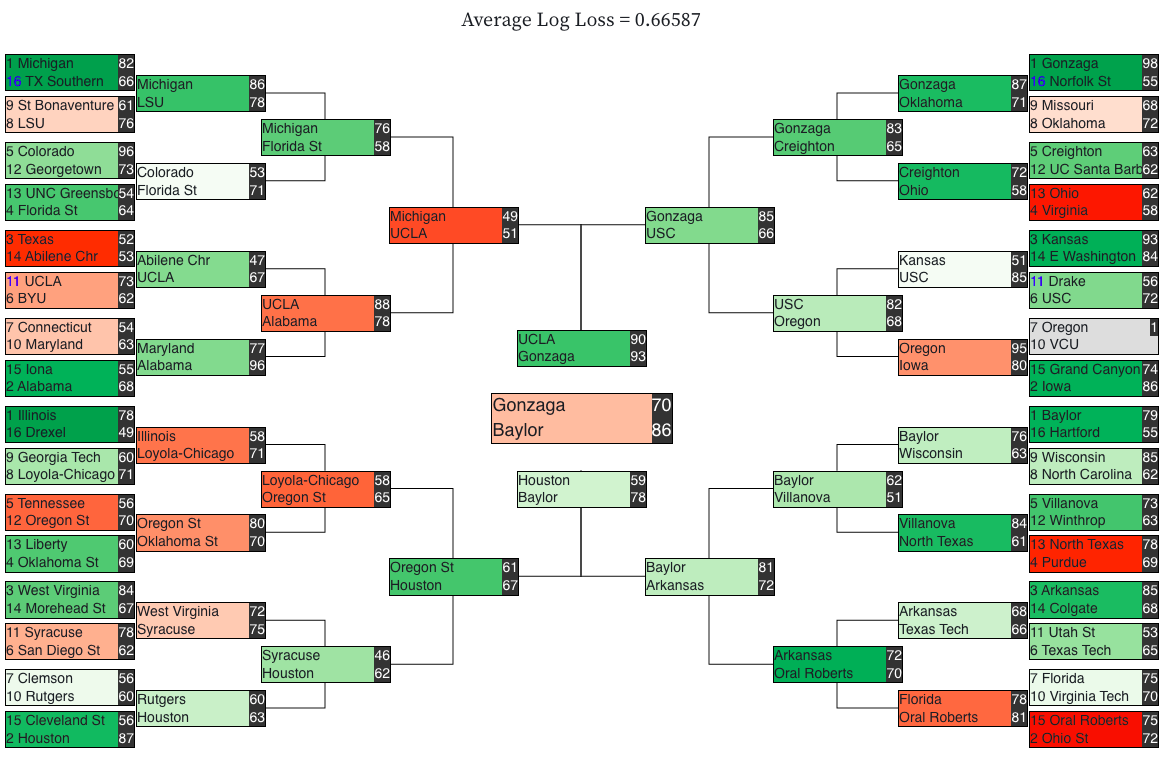

## 2022 Predictions

Now, we are gonna predict the results for each game in the 2022 tourament and print the results

**Steps**

(1) Import Train & Test Sets and combine with Kenpom data

(2) Prepare sets for model training

(3) Use Lazy Predict to test multiple model types

(4) Apply a ExtraTreesClassifier to predict the win probility of each potential game

(5) Analyze Results

## Import Packages

In [14]:
import numpy as np
import pandas as pd
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import log_loss, accuracy_score
from tqdm.notebook import tqdm
import lazypredict
from lazypredict.Supervised import LazyClassifier
import xgboost as xgb
import glob
import os
import gc
from rpy2 import robjects
import PyPDF2
import cv2
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (40,40)

## Set Path, Import Datasets, & Merge with Kenpom

Make sure to update the PATH to wherever your files are located

In [15]:
# Set Path
PATH = ""
os.chdir(PATH)
print(os.getcwd())

# Loading Datasets
train = pd.read_csv("inputs/tourney.csv")
test = pd.read_csv('inputs/test.csv')
kenpom = pd.read_csv('inputs/kenpom.csv')
kenpom = kenpom.drop(['team'],axis = 1)

/Users/matthewdenko/Documents/March_Madness_Predictions/March_Madness/march_madness_2022


In [16]:
# Merging train with Kenpom
train = train.merge(kenpom, how='left', left_on=['Season','TeamID1'],right_on=['year','teamid_x'])
train = train.merge(kenpom, how='left', left_on=['Season','TeamID2'],right_on=['year','teamid_x'])
train = train.drop_duplicates()
train.head()

Season  TeamID1  TeamID2  result  win_pct_A_1  win_pct_N_1  win_pct_H_1  \
0     2003     1421     1411       1         0.12         1.00         0.83   
16    2003     1112     1436       1         0.92         0.00         0.93   
17    2003     1113     1272       1         0.40         0.50         0.80   
18    2003     1141     1166       1         0.64         1.00         0.92   
22    2003     1143     1301       1         0.64         0.25         0.93   

    win_pct_All_1  win_pct_A_2  win_pct_N_2  ...  luck_rank_y  sos_pyth_y  \
0            0.45         0.33         0.75  ...        75.00      -12.96   
16           0.89         0.50         0.60  ...       119.00       -5.14   
17           0.62         0.64         1.00  ...       151.00        4.83   
18           0.79         0.64         1.00  ...        99.00       -0.19   
22           0.72         0.30         0.50  ...       223.00        8.48   

    sos_pyth_rank_y  sos_oppo_y  sos_oppo_rank_y  sos_oppd_y  sos_oppd_rank_y  \
0            321.00       94.40           322.00      107.40           314.00   
16           251.00       99.30           249.00      104.40           245.00   
17            84.00      103.40           133.00       98.60            54.00   
18           155.00      102.50           159.00      102.70           168.00   
22            34.00      106.90            22.00       98.40            49.00   

    ncsos_pyth_y  ncsos_pyth_rank_y  teamid_x_y  
0          -8.09             308.00     1411.00  
16         -2.29             213.00     1436.00  
17          3.33              81.00     1272.00  
18         -0.51             164.00     1166.00  
22         -6.48             292.00     1301.00  

[5 rows x 117 columns]

In [17]:
# Merging test with Kenpom
test = test.merge(kenpom, how='left', left_on=['Season','TeamID1'],right_on=['year','teamid_x'])
test = test.merge(kenpom, how='left', left_on=['Season','TeamID2'],right_on=['year','teamid_x'])
test = test.drop_duplicates()
test.head()

ID  Season  TeamID1  TeamID2  win_pct_A_1  win_pct_N_1  \
0  2022_1103_1104    2022     1103     1104         0.67         0.67   
1  2022_1103_1112    2022     1103     1112         0.67         0.67   
2  2022_1103_1116    2022     1103     1116         0.67         0.67   
3  2022_1103_1120    2022     1103     1120         0.67         0.67   
4  2022_1103_1124    2022     1103     1124         0.67         0.67   

   win_pct_H_1  win_pct_All_1  win_pct_A_2  win_pct_N_2  ...  luck_rank_y  \
0         0.77           0.71         0.36         0.50  ...          226   
1         0.77           0.71         0.75         1.00  ...           77   
2         0.77           0.71         0.56         0.60  ...          117   
3         0.77           0.71         0.70         0.67  ...          271   
4         0.77           0.71         0.73         0.75  ...          138   

   sos_pyth_y  sos_pyth_rank_y  sos_oppo_y  sos_oppo_rank_y  sos_oppd_y  \
0       12.79                1      109.70                3       96.90   
1        6.34               67      106.00               75       99.70   
2        7.93               46      106.80               56       98.90   
3        8.77               34      107.20               44       98.50   
4       10.71               12      107.40               39       96.70   

   sos_oppd_rank_y  ncsos_pyth_y  ncsos_pyth_rank_y  teamid_x_y  
0                7         10.22                 11     1104.00  
1               57         -0.22                170     1112.00  
2               35         -2.79                251     1116.00  
3               26          4.16                 58     1120.00  
4                5         -1.65                215     1124.00  

[5 rows x 117 columns]

## Prep Data For Model Training

In [18]:
# Setting X & Y for test
y = train["result"]
s = train["Season"]
X = train.drop(['Season','TeamID1','TeamID2','result','teamid_x_y'], axis=1)
X_test = test.drop(['ID', 'Season','TeamID1','TeamID2','teamid_x_y'], axis=1)

In [19]:
# Shaping data
train_oof = np.zeros((X.shape[0],))
test_preds = 0
train_oof.shape

# train test split
NUM_FOLDS = 10
kf = GroupKFold(n_splits=NUM_FOLDS)
max_iter = 550

# Training and running model predictions
for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(X, y, s))):
        #print(f'Fold {f}')
        train_df, val_df = X.iloc[train_ind], X.iloc[val_ind]
        train_target, val_target = y.iloc[train_ind], y.iloc[val_ind]
        train_df = train_df.fillna(0)
        val_df = val_df.fillna(0)

0it [00:00, ?it/s]

In [20]:
# Running Multiple Models to quickly test which classifier is most accurate
clf = LazyClassifier(verbose=0,ignore_warnings=True,custom_metric = log_loss)
models, predictions = clf.fit(train_df,X, train_target,y)
models

100%|██████████| 29/29 [00:17<00:00,  1.62it/s]


Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
ExtraTreesClassifier               0.97               0.97     0.97      0.97   
RandomForestClassifier             0.96               0.96     0.96      0.96   
LGBMClassifier                     0.96               0.96     0.96      0.96   
DecisionTreeClassifier             0.96               0.96     0.96      0.96   
XGBClassifier                      0.96               0.96     0.96      0.96   
ExtraTreeClassifier                0.95               0.95     0.95      0.95   
LabelSpreading                     0.94               0.94     0.94      0.94   
LabelPropagation                   0.94               0.94     0.94      0.94   
BaggingClassifier                  0.93               0.93     0.93      0.93   
NuSVC                              0.89               0.89     0.89      0.89   
SVC                                0.85               0.85     0.85      0.85   
AdaBoostClassifier                 0.81               0.81     0.81      0.81   
LogisticRegression                 0.80               0.80     0.80      0.80   
CalibratedClassifierCV             0.80               0.80     0.80      0.80   
LinearSVC                          0.80               0.80     0.80      0.80   
QuadraticDiscriminantAnalysis      0.80               0.80     0.80      0.80   
RidgeClassifier                    0.79               0.79     0.79      0.79   
LinearDiscriminantAnalysis         0.79               0.79     0.79      0.79   
RidgeClassifierCV                  0.79               0.79     0.79      0.79   
KNeighborsClassifier               0.76               0.76     0.76      0.76   
PassiveAggressiveClassifier        0.76               0.76     0.76      0.76   
Perceptron                         0.76               0.76     0.76      0.76   
SGDClassifier                      0.76               0.76     0.76      0.76   
BernoulliNB                        0.74               0.74     0.74      0.74   
GaussianNB                         0.73               0.73     0.73      0.73   
NearestCentroid                    0.73               0.73     0.73      0.73   
DummyClassifier                    0.50               0.50     0.50      0.50   

                               log_loss  Time Taken  
Model                                                
ExtraTreesClassifier               1.13        0.59  
RandomForestClassifier             1.29        1.41  
LGBMClassifier                     1.45        1.94  
DecisionTreeClassifier             1.49        0.24  
XGBClassifier                      1.52        1.79  
ExtraTreeClassifier                1.75        0.04  
LabelSpreading                     1.90        0.39  
LabelPropagation                   1.90        0.29  
BaggingClassifier                  2.27        1.37  
NuSVC                              3.77        1.14  
SVC                                5.31        1.01  
AdaBoostClassifier                 6.55        1.51  
LogisticRegression                 6.79        0.13  
CalibratedClassifierCV             6.89        2.75  
LinearSVC                          7.00        0.99  
QuadraticDiscriminantAnalysis      7.05        0.11  
RidgeClassifier                    7.30        0.07  
LinearDiscriminantAnalysis         7.33        0.13  
RidgeClassifierCV                  7.34        0.10  
KNeighborsClassifier               8.14        1.24  
PassiveAggressiveClassifier        8.16        0.06  
Perceptron                         8.28        0.06  
SGDClassifier                      8.32        0.13  
BernoulliNB                        9.14        0.06  
GaussianNB                         9.17        0.05  
NearestCentroid                    9.23        0.05  
DummyClassifier                   17.34        0.05

## Train and Execute Model

Looking at the results above, the Extra Trees Classifier performed the best. It had the highest accuracy and the lowest log loss.

So, unlike 2021 where we used a Gradient Boosting Classifier we are going to try an Extra Trees Classifier.

We are gonna train a ExtraTreesClassifier from sklearn. 

The Extra Trees Classifier classifier implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [21]:
# Setting Model Parameters
NUM_FOLDS = 10
kf = GroupKFold(n_splits=NUM_FOLDS)
max_iter = 550

# Training and running model predictions
for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(X, y, s))):
        #print(f'Fold {f}')
        train_df, val_df = X.iloc[train_ind], X.iloc[val_ind]
        train_target, val_target = y.iloc[train_ind], y.iloc[val_ind]
        train_df = train_df.fillna(0)
        val_df = val_df.fillna(0)
        #model = ExtraTreesClassifier(max_iter=max_iter, validation_fraction=None, learning_rate=0.01, max_depth=2, min_samples_leaf=32)
        model = ExtraTreesClassifier()

        model =  model.fit(train_df, train_target)
        temp_oof = model.predict_proba(val_df)[:,1]
        temp_test = model.predict_proba(X_test)[:,1]

        train_oof[val_ind] = temp_oof
        test_preds += temp_test/NUM_FOLDS
        
        print(log_loss(val_target, temp_oof))

0it [00:00, ?it/s]

0.5217488796413313
0.4675413532876759
0.5003285630074428
0.49721920641326584
0.49588374593913376
0.4922101186493693
0.49995605912992347
0.4967566020301191
0.5571887221369959
0.589934932182794


## Evaluate Model Performance Measures

In [22]:
# Evaluating Log Loss and Accuracy
X = X.fillna(0)
y_preds = model.predict(X)
y_probs = model.predict_proba(X)
loss = log_loss(y, train_oof)
acc = accuracy_score(y,y_preds)
print("Logg Loss:", f'{loss:,.2f}')
print("\nAccuracy Score:", f'{acc:,.2f}')

Logg Loss: 0.51

Accuracy Score: 0.96


The model performance is pretty good. An accuracy score of 96% is very high and the log loss is relatively low as well. Next we are gonna export the predictions for 2022 and see how the bracket looks!

In [23]:
# Saving Probabilities
np.save('train_oof', train_oof)
np.save('test_preds', test_preds)

## Export Kaggle Submission File

In [24]:
# Reading in 2022 data
test = pd.read_csv('inputs/test.csv')
MSampleSubmission = pd.read_csv('inputs/MSampleSubmissionStage2.csv')

In [25]:
# Shaping Predictions for submission file
idx = test_preds.shape[0] //2
test_preds[idx:] = 1 - test_preds[idx:]

pred = pd.concat([test.ID, pd.Series(test_preds)], axis=1).groupby('ID')[0]\
        .mean().reset_index().rename(columns={0:'Pred'})
sub = MSampleSubmission.drop(['Pred'],axis=1).merge(pred, on='ID')
sub.to_csv('outputs/submission2.csv', index=False)
sub.head()


ID  Pred
0  2022_1103_1104  0.23
1  2022_1103_1112  0.08
2  2022_1103_1116  0.17
3  2022_1103_1120  0.10
4  2022_1103_1124  0.08

## Bracket

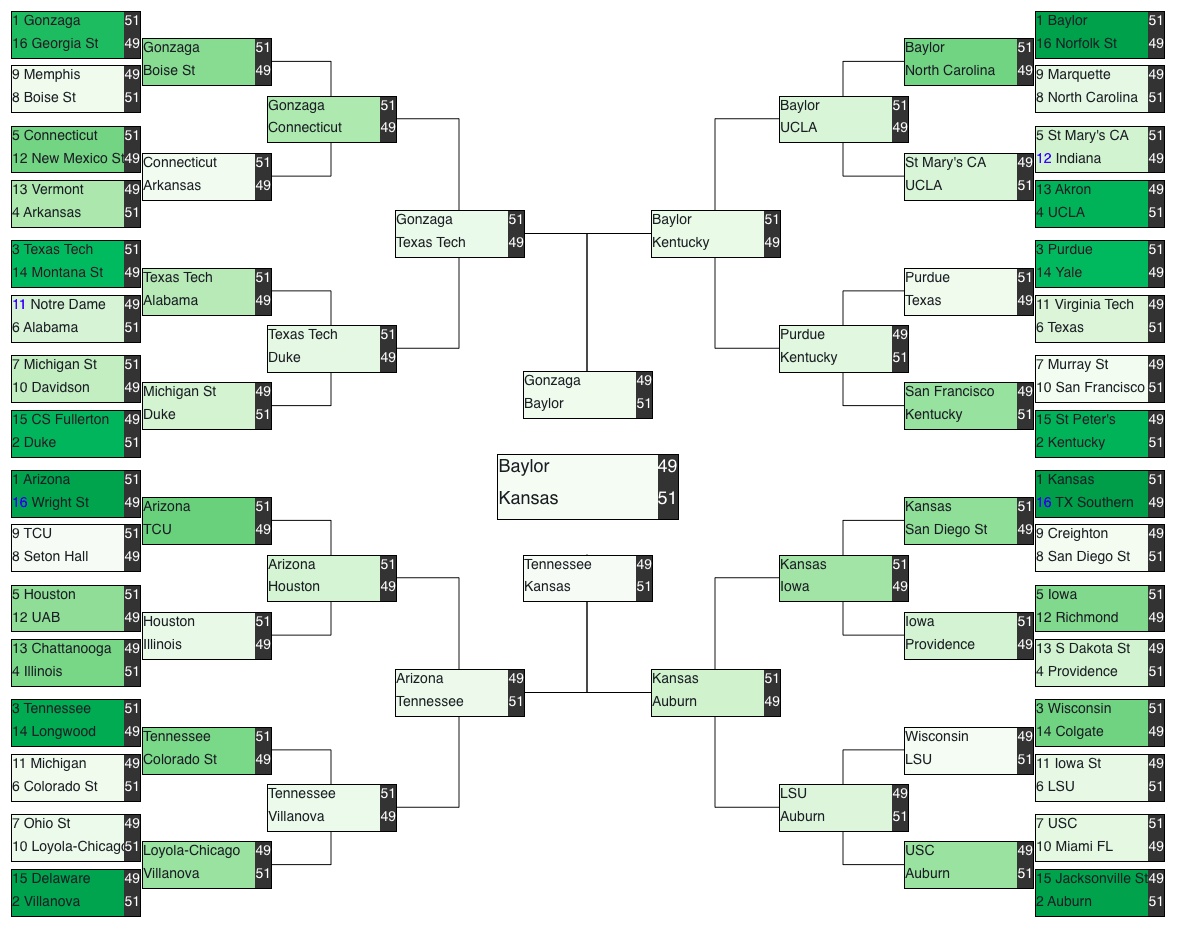

## Conclusion

The model generated strong results for past touraments (strong accuarcy score, low log loss). However, we can't measure overfit effectively because we don't have the performance of the test set. If I had more time I would split the historical data into a train and test set to help reduce the overfit possiblity, however I wanted to submit my predictions before the tourament started. 

In the end the model predicted very closely to the actual tournament seeds. This is not suprising because many of the same inputs that the tourament takes into consideration when seeding is similar to the input used in this model prediction. This model is what they call in the bracket industry CHALK! There are only a few upsets, and it predicts an all 1 seed final four. However, Kansas is predicted to win it all when they are ranked as the 4th overall number 1 seed. Please do not use this model as betting advice.